# Evaluating Bot Performance (Chess)

In [1]:
import os
import numpy as np
import seaborn as sb
from datetime import timedelta
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

parent = '/'.join(s for s in os.getcwd().split('/')[:-1])
print(parent)

/Users/benbellerose/Documents/GitHub/chappie.ai


In [2]:
import pandas as pd

ai = 'test_v6'

game_df = pd.read_csv(f'{parent}/skills/chess/data/models/{ai}/logs/game_log.csv')
game_df.head(5)

,state0,state1,state2,state3,state4,state5,state6,state7,state8,state9,...,prob4093,prob4094,prob4095,action,time,value,reward,ELO,Game-ID,Date
0,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,3307.0,1.287546,-1.0,0.0,NaN,SJM53MFYSTBK4ML,2022-04-01 10:48:31.429189
1,1.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,853.0,1.279088,1.0,0.0,NaN,SJM53MFYSTBK4ML,2022-04-01 10:48:31.429189
2,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,3177.0,1.172452,-1.0,0.0,NaN,SJM53MFYSTBK4ML,2022-04-01 10:48:31.429189
3,1.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,723.0,1.277727,1.0,0.0,NaN,SJM53MFYSTBK4ML,2022-04-01 10:48:31.429189
4,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,3364.0,1.171887,-1.0,0.0,NaN,SJM53MFYSTBK4ML,2022-04-01 10:48:31.429189


## Game Play

In [3]:
def parse_move(move):
    x_map = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #Board x representation
    y_map = ['8', '7', '6', '5', '4', '3', '2', '1'] #Board y representation
    b_a = int(move['action'])
    a_map = np.zeros(4096)
    a_map[b_a] = 1
    a_map = a_map.reshape((8,8,8,8))
    a_index = [(cy, cx, ny, nx) for cy, cx, ny, nx in zip(*np.where(a_map == 1))][0]
    c_p = f'{x_map[a_index[1]]}{y_map[a_index[0]]}'
    n_p = f'{x_map[a_index[3]]}{y_map[a_index[2]]}'
    return (c_p, n_p)

In [4]:
play_time = game_df['time'].sum()

print('Total Play Time')
print('---------------')
print(f'{ai} = {timedelta(seconds=play_time)}')

Total Play Time
---------------
test_v6 = 10:32:54.653324


### Win Distribution

Knowing the win distrabution helps know how balanced our training data is being.

In [5]:
results = []
for g, g_df in game_df.groupby('Game-ID'):
    results.append({'game':g, 'result':g_df.iloc[0]['value'], 'duration':len(g_df)})
results = pd.DataFrame(results)
print(f'Total Games Played = {len(results)}')
results['result'].value_counts(normalize=True).to_frame().T

Total Games Played = 160


,0.0,-1.0,1.0
result,0.525,0.25625,0.21875


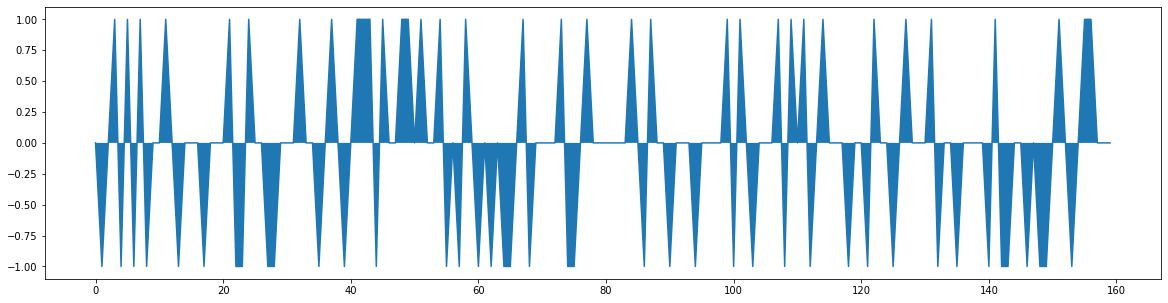

In [6]:
results['result'].plot.line(figsize=(20, 5), legend=False)
plt.fill_between(results.index,results['result'])
plt.show()

### Game Duration

<AxesSubplot:>

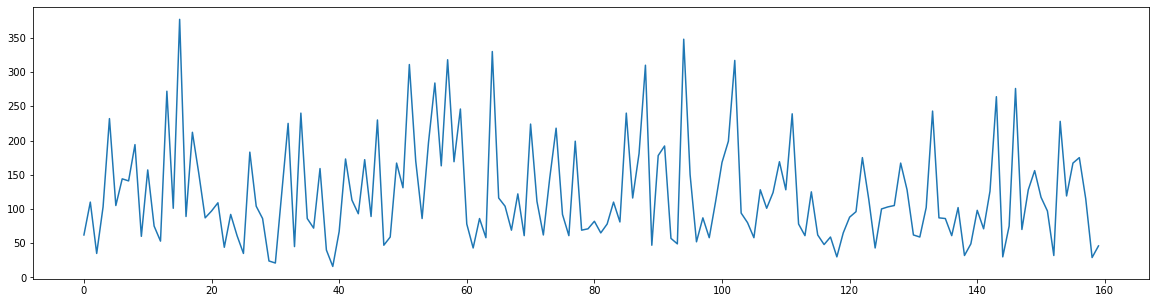

In [7]:
results['duration'].plot.line(figsize=(20, 5), legend=False)

### Move Distribution

In [8]:
x_map = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #Board x representation
y_map = ['8', '7', '6', '5', '4', '3', '2', '1'] #Board y representation

o_results = []
for g, g_log in game_df.dropna(subset=['ELO']).groupby('Game-ID'):
    move = 1
    for i, row in g_log.iterrows():
        c_pos, n_pos = parse_move(row)
        o_results.append({
            'x': x_map.index(n_pos[0]), 
            'y':y_map.index(n_pos[1]),
            'z':move, 
            'c':-1 if (move % 2) == 0 else 1
        })
        move += 1
o_results = pd.DataFrame(o_results)

### White Player Move Distribution

In [9]:
w_results = o_results[o_results['c']==1]
w_m_count_df = []
for m, m_df in w_results.groupby('z'):
    m_hold = {}
    for i, row in m_df.iterrows():
        board = np.zeros((8,8))
        board[row['y']][row['x']] = 1
        board = board.reshape((64))
        flat_pos = np.where(board == 1)[0][0]
        if flat_pos in m_hold:
            m_hold[flat_pos] += 1
        else:
            m_hold[flat_pos] = 1
    for x in range(64):
        w_m_count_df.append({
            'x':x,
            'y':m,
            'z':m_hold[x] if x in m_hold else 0
        })
    
w_m_count_df = pd.DataFrame(w_m_count_df).fillna(0)

Text(0.5, 0, 'action occurrence')

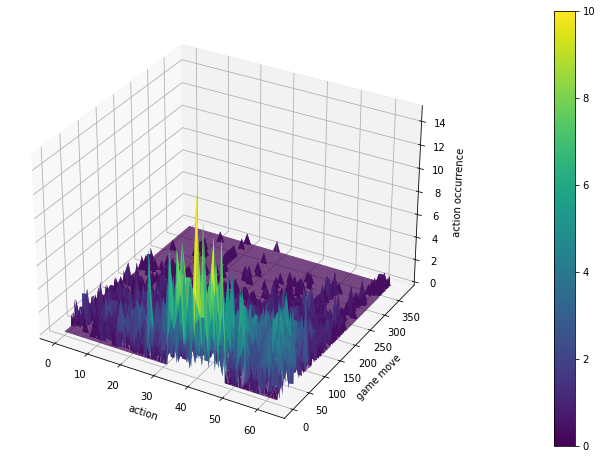

In [10]:
plt.rcParams['figure.figsize'] = (40,8)

ax = plt.axes(projection='3d')
plot3D = ax.plot_trisurf(w_m_count_df['x'], w_m_count_df['y'], w_m_count_df['z'], cmap='viridis', linewidth=0.5)

cb = plt.colorbar(plot3D)

ax.set_xlabel('action')
ax.set_ylabel('game move')
ax.set_zlabel('action occurrence')

### Black Player Move Distribution

In [11]:
b_results = o_results[o_results['c']==-1]
b_m_count_df = []
for m, m_df in b_results.groupby('z'):
    m_hold = {}
    for i, row in m_df.iterrows():
        board = np.zeros((8,8))
        board[row['y']][row['x']] = 1
        board = board.reshape((64))
        flat_pos = np.where(board == 1)[0][0]
        if flat_pos in m_hold:
            m_hold[flat_pos] += 1
        else:
            m_hold[flat_pos] = 1
    for x in range(64):
        b_m_count_df.append({
            'x':x,
            'y':m,
            'z':m_hold[x] if x in m_hold else 0
        })
    
b_m_count_df = pd.DataFrame(b_m_count_df).fillna(0)

Text(0.5, 0, 'action occurrence')

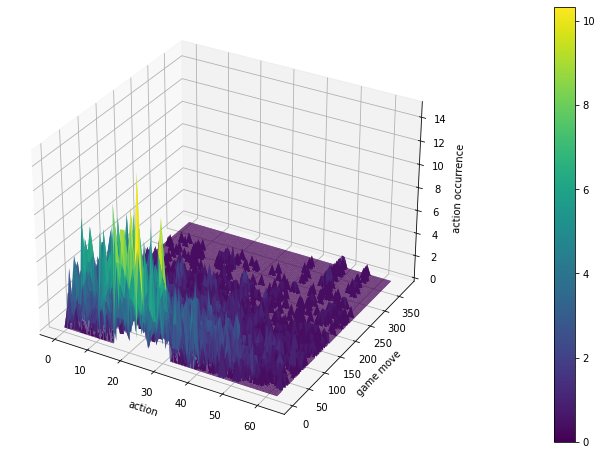

In [12]:
plt.rcParams['figure.figsize'] = (40,8)

ax = plt.axes(projection='3d')
plot3D = ax.plot_trisurf(b_m_count_df['x'], b_m_count_df['y'], b_m_count_df['z'], cmap='viridis', linewidth=0.5)

cb = plt.colorbar(plot3D)

ax.set_xlabel('action')
ax.set_ylabel('game move')
ax.set_zlabel('action occurrence')

### White Opening Moves

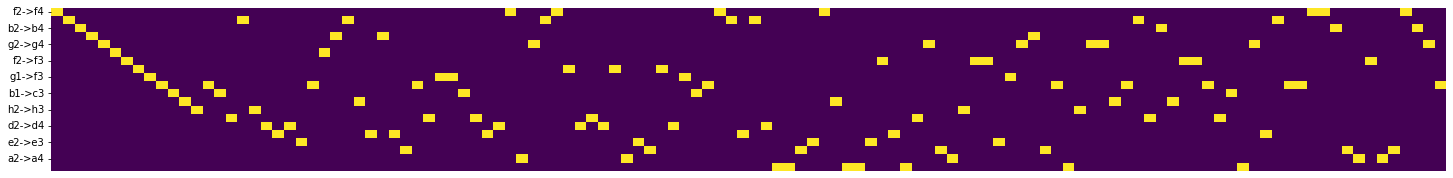

In [13]:
o_results = []
for g, g_log in game_df.dropna(subset=['ELO']).groupby('Game-ID'):
    c_pos, n_pos = parse_move(g_log.iloc[0])
    o_results.append({f'{c_pos}->{n_pos}':1})
o_results = pd.DataFrame(o_results).fillna(0).T

plt.rcParams['figure.figsize'] = [25, 3] #Resize graph 
sb.heatmap(o_results, cmap='viridis', cbar=False, xticklabels=False, linewidths=0)
plt.show()

### Black Opening Moves

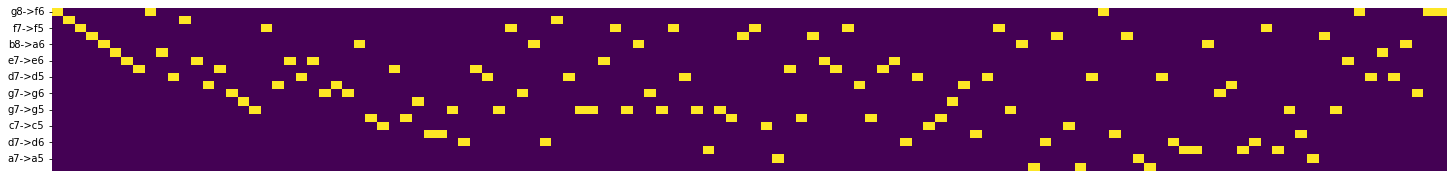

In [14]:
o_results = []
for g, g_log in game_df.dropna(subset=['ELO']).groupby('Game-ID'):
    c_pos, n_pos = parse_move(g_log.iloc[1])
    o_results.append({f'{c_pos}->{n_pos}':1})
o_results = pd.DataFrame(o_results).fillna(0).T

plt.rcParams['figure.figsize'] = [25, 3] #Resize graph 
sb.heatmap(o_results, cmap='viridis', cbar=False, xticklabels=False, linewidths=0)
plt.show()

### Game Action Probabilities

In [15]:
'''
p_headers = [h for h in game_df if 'prob' in h]

a_probs = []
for i, row in game_df[p_headers].iterrows():
    a_probs.append({k.replace('prob',''):v for k, v in row[(row > 0)].to_dict().items()})

a_probs = pd.DataFrame(a_probs)
plt.rcParams['figure.figsize'] = [25, 5] #Resize graph 
sb.heatmap(a_probs.T, cmap='magma', xticklabels=False, linewidths=0)
plt.show()
'''

"\np_headers = [h for h in game_df if 'prob' in h]\n\na_probs = []\nfor i, row in game_df[p_headers].iterrows():\n    a_probs.append({k.replace('prob',''):v for k, v in row[(row > 0)].to_dict().items()})\n\na_probs = pd.DataFrame(a_probs)\nplt.rcParams['figure.figsize'] = [25, 5] #Resize graph \nsb.heatmap(a_probs.T, cmap='magma', xticklabels=False, linewidths=0)\nplt.show()\n"

### Game Tree

In [16]:
'''
s_headers = [h for h in game_df if 'state' in h]
p_headers = [h for h in game_df if 'prob' in h]

tree = {}
for i, row in game_df.iterrows():
    s_hash = hash(str(row[s_headers].tolist()))
    tree[(s_hash)] = 
    break
print(tree)


import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

G = nx.Graph()
for s in search.tree:
    for a in search.tree[s].n_s:
        G.add_edge(s,a)
        
pos = graphviz_layout(G, prog='dot')
#Display network graph -----------------------------
nx.draw(
    G, #Graph nodes & connections
    pos, #Position of graph
    with_labels=True #Labels on nodes
)
plt.rcParams['figure.figsize'] = [40, 40] #Resize graph
plt.show()
'''

"\ns_headers = [h for h in game_df if 'state' in h]\np_headers = [h for h in game_df if 'prob' in h]\n\ntree = {}\nfor i, row in game_df.iterrows():\n    s_hash = hash(str(row[s_headers].tolist()))\n    tree[(s_hash)] = \n    break\nprint(tree)\n\n\nimport matplotlib.pyplot as plt\nimport networkx as nx\nimport pydot\nfrom networkx.drawing.nx_pydot import graphviz_layout\n\nG = nx.Graph()\nfor s in search.tree:\n    for a in search.tree[s].n_s:\n        G.add_edge(s,a)\n        \npos = graphviz_layout(G, prog='dot')\n#Display network graph -----------------------------\nnx.draw(\n    G, #Graph nodes & connections\n    pos, #Position of graph\n    with_labels=True #Labels on nodes\n)\nplt.rcParams['figure.figsize'] = [40, 40] #Resize graph\nplt.show()\n"

### ELO Rating

<AxesSubplot:>

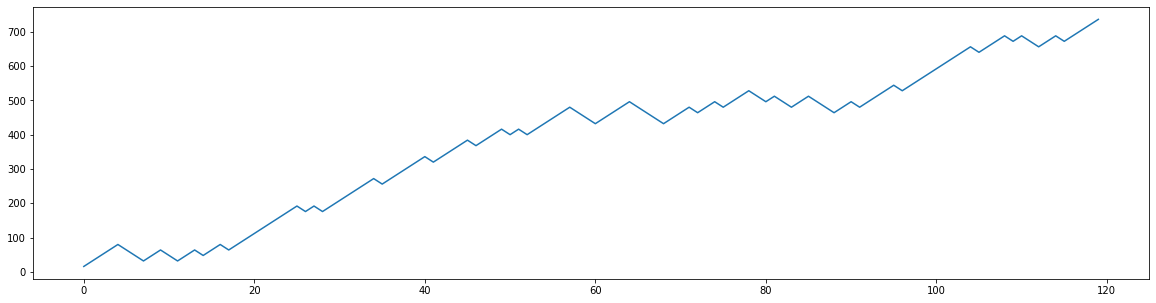

In [17]:
elo_df = game_df.drop_duplicates(subset=['Game-ID']).dropna().reset_index()
elo_df['ELO'].dropna().plot.line(figsize=(20, 5), legend=False)

## Training Results

In [18]:
model_list = [m for m in os.listdir(f'{parent}/skills/chess/data/models') if m != '.DS_Store' and '(temp)' not in m]

training_df = pd.DataFrame()
for ai in model_list:
    training_df = training_df.append(pd.read_csv(f'{parent}/skills/chess/data/models/{ai}/logs/training_log.csv'), ignore_index=False)
training_df = pd.DataFrame(training_df)
training_df = training_df.replace(0, np.nan)
training_df['Epoch'] = training_df['Epoch'].fillna(0)
training_df.head(5)

,Date,Epoch,Samples,Time,value loss,policy loss,state loss,reward loss,model,hidden loss,backbone loss
0,2022-02-17 17:29:49.942162,0.0,329,2.161024,1.083051,0.002290,2.439279,0.105770,skills/chess/data/models/test_v4,NaN,NaN
1,2022-02-17 17:29:52.053189,1.0,329,4.272052,1.090668,0.002291,2.427909,0.107115,skills/chess/data/models/test_v4,NaN,NaN
2,2022-02-17 17:29:54.159878,2.0,329,6.378740,1.098556,0.002289,2.513970,0.088657,skills/chess/data/models/test_v4,NaN,NaN
3,2022-02-17 17:29:56.298828,3.0,329,8.517690,1.079761,0.002289,2.440815,0.093885,skills/chess/data/models/test_v4,NaN,NaN
4,2022-02-17 17:29:58.408034,4.0,329,10.626896,1.099509,0.002289,2.460947,0.107589,skills/chess/data/models/test_v4,NaN,NaN


In [19]:
training_time = {}
for g, g_df in training_df.groupby('model'):
    training_time[g] = g_df['Time'].sum()

print('Training Time')
print('-------------')
for g, t in training_time.items():
    print(f'{g} = {timedelta(seconds=t/60)}')

Training Time
-------------
skills/chess/data/models/test_V3 = 4:36:05.805490
skills/chess/data/models/test_v4 = 3:29:39.107867
skills/chess/data/models/test_v5 = 3:56:50.351193
skills/chess/data/models/test_v6 = 0:41:20.251303


In [20]:
from IPython.display import display

for m, m_df in training_df.groupby('model'):
    print(m)
    display(m_df.describe())

skills/chess/data/models/test_V3


,Epoch,Samples,Time,value loss,policy loss,state loss,reward loss,hidden loss,backbone loss
count,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,2690.000000,12.000000,12.000000
mean,4.500000,339.060223,369.497520,1.005559,0.002290,2.107630,0.114078,0.932328,3.134059
std,2.872815,2255.676504,2355.918794,0.323667,0.000004,0.795743,0.085899,0.079682,0.807072
min,0.000000,7.000000,0.093187,0.026196,0.002277,0.519199,0.004890,0.762776,2.029454
25%,2.000000,123.000000,3.930346,1.042209,0.002288,1.544805,0.057669,0.893974,2.569310
50%,4.500000,197.500000,7.910961,1.080006,0.002290,2.028811,0.088779,0.936149,3.060186
75%,7.000000,280.000000,14.342288,1.131258,0.002292,2.525358,0.142109,0.960646,3.808918
max,9.000000,55998.000000,26604.144906,1.702780,0.002306,5.127199,0.789817,1.070265,4.445956


skills/chess/data/models/test_v4


,Epoch,Samples,Time,value loss,policy loss,state loss,reward loss,hidden loss,backbone loss
count,2610.000000,2610.000000,2610.000000,2610.000000,2610.000000,2610.000000,2610.000000,11.000000,11.000000
mean,4.500000,320.288889,289.174893,1.029440,0.002290,2.004426,0.110503,1.021917,0.008810
std,2.872832,2099.289720,1875.450172,0.291503,0.000004,0.841211,0.075748,0.062163,0.000707
min,0.000000,22.000000,0.246940,0.021050,0.002267,0.500926,0.015753,0.952596,0.008128
25%,2.000000,126.000000,3.382890,1.040548,0.002287,1.361445,0.059282,0.974133,0.008260
50%,4.500000,187.000000,6.908816,1.077898,0.002289,1.846571,0.086400,0.997290,0.008717
75%,7.000000,265.000000,12.382811,1.133026,0.002292,2.501397,0.144182,1.078900,0.008956
max,9.000000,54689.000000,19368.213235,2.128939,0.002301,5.109773,0.574323,1.115148,0.010176


skills/chess/data/models/test_v5


,Epoch,Samples,Time,value loss,policy loss,state loss,reward loss,hidden loss,backbone loss
count,2790.000000,2790.000000,2790.000000,2790.000000,2790.000000,2790.000000,2.790000e+03,13.000000,13.000000
mean,4.500000,335.065591,305.598950,0.987743,0.002264,4.855796,3.891959e-02,0.850458,0.004009
std,2.872796,2262.807937,1885.018245,0.260521,0.000018,22.390271,3.565441e-02,0.018718,0.000583
min,0.000000,17.000000,0.150075,0.004881,0.002143,0.435900,1.050211e-15,0.818335,0.003421
25%,2.000000,116.000000,3.193394,1.015573,0.002258,1.456457,1.646670e-02,0.840785,0.003628
50%,4.500000,185.000000,6.591537,1.039670,0.002267,1.999948,2.989472e-02,0.847849,0.003795
75%,7.000000,273.000000,12.518461,1.070790,0.002274,2.586243,4.972783e-02,0.863279,0.004281
max,9.000000,54545.000000,20660.836624,1.726392,0.002295,305.023081,4.832499e-01,0.883396,0.005459


skills/chess/data/models/test_v6


,Epoch,Samples,Time,value loss,policy loss,state loss,reward loss,hidden loss,backbone loss
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,4.000000e+02,40.000000,40.000000
mean,4.500000,1049.152500,372.037695,0.940693,0.002231,5.831750,2.031778e-03,0.610149,0.004985
std,2.875878,3141.677722,275.240564,0.190277,0.000023,12.547606,8.923810e-03,0.113372,0.000929
min,0.000000,44.000000,2.273993,0.000111,0.002172,0.889214,1.743924e-15,0.506207,0.004177
25%,2.000000,101.500000,129.582623,0.995899,0.002216,1.592857,1.164424e-14,0.544487,0.004449
50%,4.500000,172.000000,322.516589,1.000324,0.002234,2.519907,2.757362e-11,0.594684,0.004661
75%,7.000000,267.000000,577.013756,1.004814,0.002245,4.204810,3.081580e-05,0.610477,0.005094
max,9.000000,18194.000000,951.379479,1.106952,0.002283,87.509389,7.899762e-02,1.175315,0.008521


### Hidden Layer Loss

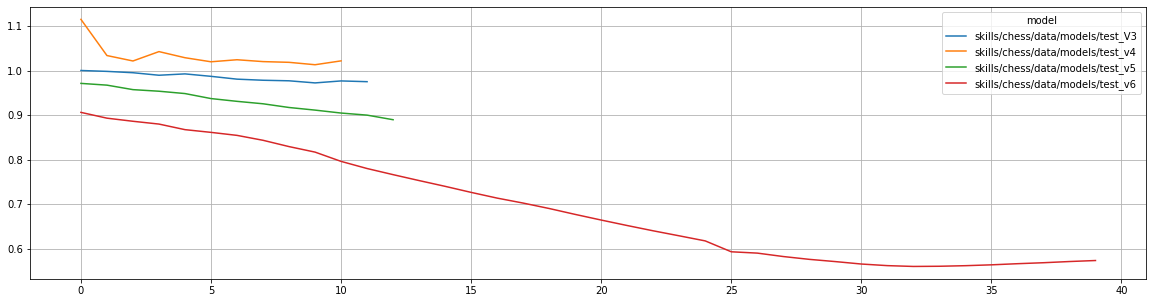

In [21]:
if 'hidden loss' in training_df:
    h_df = training_df[['hidden loss','model']].dropna().reset_index()
    h_df['hidden loss'] = h_df['hidden loss'].rolling(window=25, min_periods=1).mean()
    if len(h_df) > 0 and 'model' in h_df:
        h_df = h_df.groupby('model')['hidden loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        h_df[[h for h in h_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Backbone Layer Loss

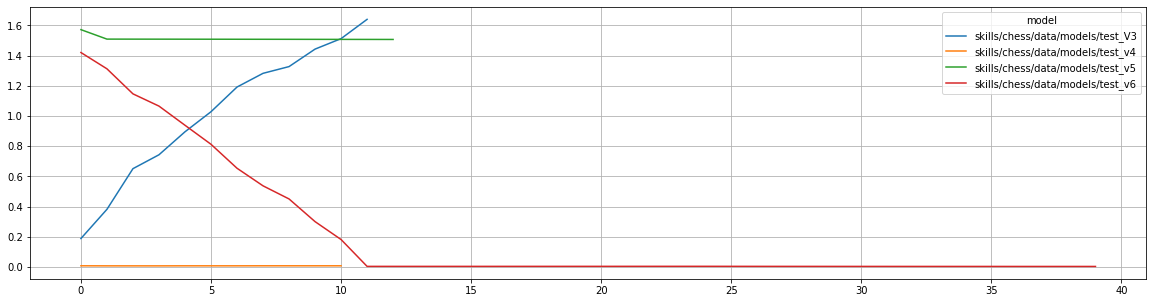

In [22]:
if 'backbone loss' in training_df:
    b_df = training_df[['backbone loss','model']].dropna().reset_index()
    b_df['backbone loss'] = b_df['backbone loss'].rolling(window=25, min_periods=1).mean()
    if len(b_df) > 0 and 'model' in b_df:
        b_df = b_df.groupby('model')['backbone loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        b_df[[h for h in b_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Chunked Cross Attention Layer Loss

In [23]:
if 'Cca loss' in training_df:
    cca_df = training_df[['Cca loss','model']].dropna().reset_index()
    cca_df['Cca loss'] = cca_df['Cca loss'].rolling(window=25, min_periods=1).mean()
    if len(cca_df) > 0 and 'model' in cca_df:
        cca_df = h_df.groupby('model')['Cca loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        cca_df[[h for h in cca_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Value Head Loss

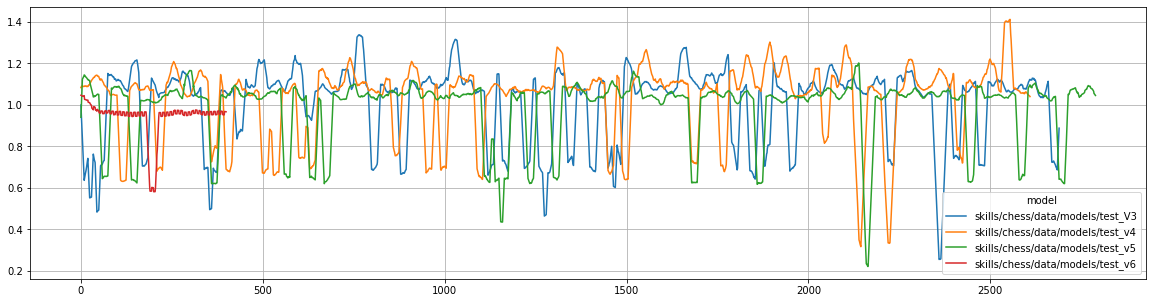

In [24]:
if 'value loss' in training_df:
    v_df = training_df[['value loss','model']].dropna().reset_index()
    v_df['value loss'] = v_df['value loss'].rolling(window=25, min_periods=1).mean()
    if len(v_df) > 0 and 'model' in v_df:
        v_df = v_df.groupby('model')['value loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        v_df[[h for h in v_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Policy Head Loss

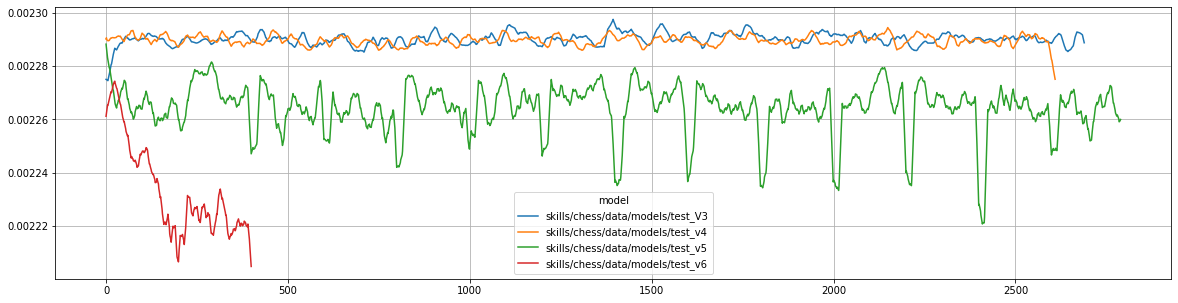

In [25]:
if 'policy loss' in training_df:
    p_df = training_df[['policy loss','model']].dropna().reset_index()
    p_df['policy loss'] = p_df['policy loss'].dropna().rolling(window=25, min_periods=1).mean()
    if len(p_df) > 0 and 'model' in p_df:
        p_df = p_df.groupby('model')['policy loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        p_df[[h for h in h_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Next State Head Loss

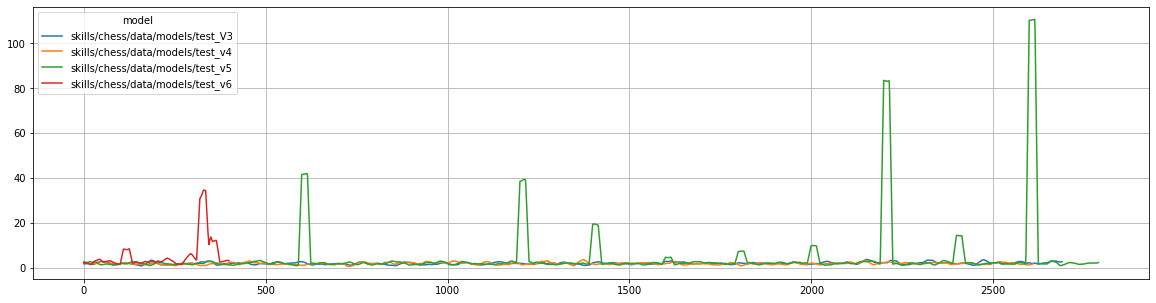

In [26]:
if 'state loss' in training_df:
    s_df = training_df[['state loss','model']].dropna().reset_index()
    s_df['state loss'] = s_df['state loss'].dropna().rolling(window=25, min_periods=1).mean()
    if len(s_df) > 0 and 'model' in s_df:
        s_df = s_df.groupby('model')['state loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        s_df[[h for h in s_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Reward Head Loss

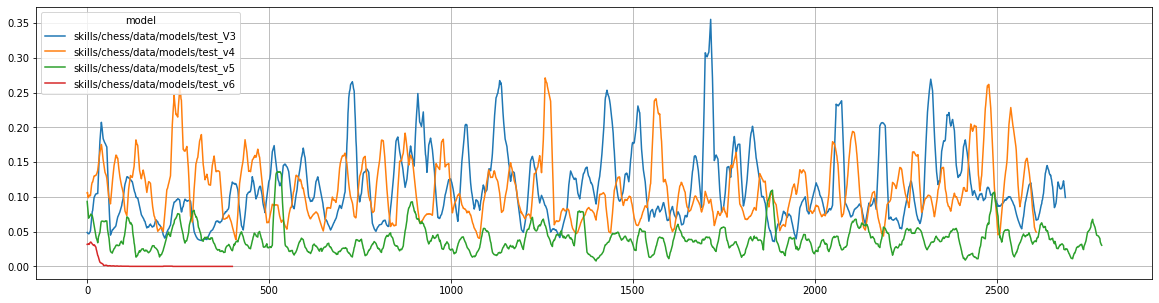

In [27]:
if 'reward loss' in training_df:
    r_df = training_df[['reward loss','model']].dropna().reset_index()
    r_df['reward loss'] = r_df['reward loss'].dropna().rolling(window=25, min_periods=1).mean()
    if len(r_df) > 0 and 'model' in r_df:
        r_df = r_df.groupby('model')['reward loss'].apply(lambda x: pd.Series(x.values)).unstack().T.reset_index()
        r_df[[h for h in r_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)